In [2]:
from google.colab import files
uploaded = files.upload()

Saving prepro.py to prepro.py


In [3]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install sklearn_crfsuite
!pip install keras==2.2.4

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-77iohksm
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-77iohksm
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=122c2c4e4366ebfdc575012a55eb1e9362cb4bc7609f69387d635f836420bf78
  Stored in directory: /tmp/pip-ephem-wheel-cache-v5e4t4np/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
     |████████████████████████████████| 757kB 4.2MB/s 
     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
import pandas as pd
import re
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split

#cusotm packages
from prepro import readstring

#keras and tensorflow packages
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from keras_contrib.metrics import crf_accuracy


#evaluation
from sklearn_crfsuite.metrics import flat_classification_report,flat_f1_score,flat_precision_score

In [0]:
#import data from my github repo
train_url = "https://raw.githubusercontent.com/deanhoperobertson/Named-Enitty-Recognition/master/Data/train.txt"
test_url = "https://raw.githubusercontent.com/deanhoperobertson/Named-Enitty-Recognition/master/Data/test.txt"
valid_url = "https://raw.githubusercontent.com/deanhoperobertson/Named-Enitty-Recognition/master/Data/valid.txt"
train = urllib.request.urlopen(train_url).read()
test = urllib.request.urlopen(test_url).read()
valid = urllib.request.urlopen(valid_url).read()
train = train.decode('utf-8')
test = test.decode('utf-8')
valid = valid.decode('utf-8')

def hasNumbers(text):
    if text.isdigit():
        return "1"
    elif re.search(r'\d',text) and re.search(r'\,|\.',text):
        return "1" 
    else:
        if re.search(r'\d', text):
            return(re.sub('\d','D', text))
        else:
            return text

def readstring(filename, meth):
    f = filename.split('\n')
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        if meth.lower()=="numbers":
            sentence.append([hasNumbers(splits[0]), splits[-1].strip()])
        else:
            sentence.append([splits[0], splits[-1].strip()])
    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    return sentences

#preproces the txt file
train_data = readstring(train,"Numbers")
test_data = readstring(test,"Numbers")
valid_data = readstring(valid,"Numbers")

#create corpus
corpus = train_data.copy()
corpus.extend(test_data)
corpus.extend(valid_data)

In [0]:
def reformat_data(data,meth):
  if meth.lower() == "data":
    i=0
  else: i=1
  train = []
  output= []
  for sentence in data:
    words=[]
    for x in sentence:
      words.append(x[i])
    train.append(words)

  for i in train:
    string = ' '.join(i)
    output.append(string)
  return output

def get_max_length(corpus):
  length = []
  for sentence in corpus:
    length.append(len(sentence))
  return int(max(length))

def number_of_tags(corpus):
  tags=[]
  for sentence in corpus:
    for tag in sentence:
      tags.append(tag[1])
  return int(len(list(set(tags))))


MAX_LEN = get_max_length(corpus)
N_tags = number_of_tags(corpus)

train = reformat_data(train_data,"data")
test = reformat_data(test_data,"data")
valid = reformat_data(valid_data,"data")


In [0]:
# create WORD tokenizer
token_word = text.Tokenizer(char_level=False, lower=False, filters="}", oov_token='UNK')
token_word.fit_on_texts(train)

# convert text to sequence of tokens and pad them to ensure equal length vectors 
X_train = sequence.pad_sequences(token_word.texts_to_sequences(train), maxlen=MAX_LEN,padding="post")
X_test = sequence.pad_sequences(token_word.texts_to_sequences(test), maxlen=MAX_LEN,padding="post")
X_valid = sequence.pad_sequences(token_word.texts_to_sequences(valid), maxlen=MAX_LEN,padding="post")

In [0]:
train = reformat_data(train_data,"tags")
test = reformat_data(test_data,"tags")
valid = reformat_data(valid_data,"tags")

# create TAG tokenizer
token_tag = text.Tokenizer(char_level=False, lower=False, filters="}")
token_tag.fit_on_texts(train)

# convert text to sequence of tokens and pad them to ensure equal length vectors 
Y = sequence.pad_sequences(token_tag.texts_to_sequences(train), maxlen=MAX_LEN,padding="post")
# One-Hot encode categorical labels
Y_train = [to_categorical(i, num_classes=N_tags+1) for i in Y]

Y = sequence.pad_sequences(token_tag.texts_to_sequences(test), maxlen=MAX_LEN,padding="post")
# One-Hot encode categorical labels
Y_test = [to_categorical(i, num_classes=N_tags+1) for i in Y]

Y = sequence.pad_sequences(token_tag.texts_to_sequences(valid), maxlen=MAX_LEN,padding="post")
# One-Hot encode categorical labels
Y_valid = [to_categorical(i, num_classes=N_tags+1) for i in Y]

#add padding 
token_tag.index_word[0]="PAD"
sub_label = list(token_tag.index_word.values())
sub_label.remove('O')
sub_label.remove('PAD')

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%%time
#root_path = "/content/drive/My Drive/glove.6B.50d.txt"
#root_path = "/content/drive/My Drive/glove.6B.100d.txt"
#root_path = "/content/drive/My Drive/glove.6B.200d.txt"
#root_path = "/content/drive/My Drive/glove.6B.300d.txt"
root_path = "/content/drive/My Drive/glove.42B.300d.txt"
#root_path = "/content/drive/My Drive/wiki-news-300d-1M.vec"

EMBEDDING=int(re.findall("(\d{2,3})d",root_path)[0])
embeddings_index={}
f = open(root_path, encoding = "utf-8")
for line in f:
    values = line.split()
    word = ''.join(values[:-EMBEDDING])
    coefs = np.asarray(values[-EMBEDDING:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.
CPU times: user 2min 40s, sys: 6.74 s, total: 2min 47s
Wall time: 3min 3s


In [0]:
#create emedding matrix
word_index = token_word.word_index
embedding_matrix = np.zeros((len(token_word.word_index) + 1, EMBEDDING))
lower =0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
      embedding_vector = embeddings_index.get(word.lower())
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        lower +=1
      else: 
        pass
    else:
      embedding_matrix[i] = embedding_vector

In [33]:
checks=[]
words=[]
for i in range(0,len(token_word.word_index)+1):
  if embedding_matrix[i][0] == 0.0:
    checks.append(1)
    words.append(list(token_word.word_index.items())[i-1][0])
  else:
    continue

print("Missing words from Embeddings: %d (%.2f%%) \nCase Changed to find: %d" %(len(checks),(len(checks)/len(token_word.word_index)*100),lower))

Missing words from Embeddings: 1192 (5.96%) 
Case Changed to find: 9033


## Create Model

In [0]:
# Model definition

input = Input(shape=(MAX_LEN,))

model_2 = Embedding(len(token_word.word_index) + 1,output_dim=EMBEDDING,
                  weights=[embedding_matrix],input_length=MAX_LEN,
                  trainable=False,mask_zero=True)(input)

model_2 = Bidirectional(LSTM(units=150, return_sequences=True,
                           recurrent_dropout=0.1, dropout=0.3))(model_2)

model_2 = Bidirectional(LSTM(units=150, return_sequences=True,
                             recurrent_dropout=0.1,dropout=0.3))(model_2)

model_2 = TimeDistributed(Dense(50, activation="relu"))(model_2)
crf = CRF(N_tags+1)  # CRF layer
out = crf(model_2)  # output
model_2 = Model(input, out)

In [35]:
from keras import optimizers
adam=optimizers.Adam(clipnorm=1.)
adam=optimizers.Adam(clipvalue=0.5)

model_2.compile(optimizer="adam", loss=crf_loss,metrics=[crf_viterbi_accuracy])
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 124)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 124, 300)          5997600   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 124, 300)          541200    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 124, 300)          541200    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 124, 50)           15050     
_________________________________________________________________
crf_2 (CRF)                  (None, 124, 9)            558       
Total params: 7,095,608
Trainable params: 1,098,008
Non-trainable params: 5,997,600
__________________________________________________________

In [0]:
from keras.callbacks import Callback
class F1Metrics(Callback):

    def __init__(self, id2label,sub_label,train_data,pad_value=0,validation_data=None):
        super(F1Metrics, self).__init__()
        self.id2label = id2label
        self.sublabel = sub_label
        self.train_data = train_data
        self.validation_data = validation_data
        self.is_fit = validation_data is None

    def convert_idx_to_name(self, y):
        y = [[self.id2label[i] for i in row] for row in y]
        return y

    def predict(self, X, y):
        y_pred = self.model.predict_on_batch(X)
        y_true = np.argmax(y, -1)
        y_pred = np.argmax(y_pred, -1)
        y_true = self.convert_idx_to_name(y_true)
        y_pred = self.convert_idx_to_name(y_pred)
        return y_true, y_pred

    def score(self, y_true, y_pred):
        score = flat_f1_score(y_true, y_pred,average='micro',labels=sub_label)
        print(len(y_pred))
        print(' - f1: %.2f' %(score))
        return score

    def on_epoch_end(self, epoch, logs={}):
        if self.is_fit:
            self.on_epoch_end_fit(epoch, logs)
        else:
            self.on_epoch_end_fit_generator(epoch, logs)

    def on_epoch_end_fit(self, epoch, logs={}):
        X_tr,Y_tr = self.train_data
        X = self.validation_data[0]
        y = self.validation_data[1]
        y_true, y_pred = self.predict(X, y)
        score_val = self.score(y_true, y_pred)
        logs['f1_val'] = score_val
        y_true, y_pred = self.predict(X_tr,Y_tr)
        score_val = self.score(y_true, y_pred)
        logs['f1_tr'] = score_val


    def on_epoch_end_fit_generator(self, epoch, logs={}):
        y_true = []
        y_pred = []
        for X, y in self.validation_data:
            y_true_batch, y_pred_batch = self.predict(X, y)
            y_true.extend(y_true_batch)
            y_pred.extend(y_pred_batch)
        score = self.score(y_true, y_pred)
        logs['f1'] = score

f1score = F1Metrics(token_tag.index_word, sub_label,(X_train, np.array(Y_train)))

In [37]:
%%time
from keras.callbacks import EarlyStopping
BATCH_SIZE = 200
EPOCHS=30

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = model_2.fit(X_train, np.array(Y_train), 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      validation_split=0.2,
                      #validation_data = (X_valid,np.array(Y_valid)),
                      verbose=1,callbacks=[early_stopping])

Train on 11232 samples, validate on 2809 samples
Epoch 1/30
11232/11232 [==============================] - 131s 12ms/step - loss: 40.6997 - crf_viterbi_accuracy: 0.8300 - val_loss: 35.4019 - val_crf_viterbi_accuracy: 0.9119
Epoch 2/30
11232/11232 [==============================] - 125s 11ms/step - loss: 40.1811 - crf_viterbi_accuracy: 0.9308 - val_loss: 35.2563 - val_crf_viterbi_accuracy: 0.9433
Epoch 3/30
11232/11232 [==============================] - 125s 11ms/step - loss: 40.1103 - crf_viterbi_accuracy: 0.9489 - val_loss: 35.2178 - val_crf_viterbi_accuracy: 0.9527
Epoch 4/30
11232/11232 [==============================] - 124s 11ms/step - loss: 40.0789 - crf_viterbi_accuracy: 0.9566 - val_loss: 35.1994 - val_crf_viterbi_accuracy: 0.9568
Epoch 5/30
11232/11232 [==============================] - 124s 11ms/step - loss: 40.0613 - crf_viterbi_accuracy: 0.9613 - val_loss: 35.1897 - val_crf_viterbi_accuracy: 0.9597
Epoch 6/30
11232/11232 [==============================] - 123s 11ms/step - l

## Predict On Training Set

In [38]:
%%time
pred = model_2.predict(X_train, verbose=1)

14041/14041 [==============================] - 318s 23ms/step
CPU times: user 8min 13s, sys: 1min 9s, total: 9min 23s
Wall time: 5min 18s


In [39]:
# TRain Eval
preds = np.argmax(pred, axis=-1)
y_tr_true = np.argmax(Y_train, -1)

# Convert the index to tag
pred_tag = [[token_tag.index_word[i] for i in row] for row in preds]
y_tr_true_tag = [[token_tag.index_word[i] for i in row] for row in y_tr_true]
                 
                 
report = flat_classification_report(y_pred=pred_tag, y_true=y_tr_true_tag,labels=sub_label)
print(report)
#F1 Score
score=flat_f1_score(y_pred=pred_tag, y_true=y_tr_true_tag,average='micro',labels=sub_label)
print(score)  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       I-PER       0.96      0.98      0.97     11128
       I-ORG       0.94      0.79      0.86     10001
       I-LOC       0.95      0.92      0.94      8286
      I-MISC       0.93      0.80      0.86      4556
      B-MISC       0.00      0.00      0.00        37
       B-ORG       1.00      1.00      1.00        24
       B-LOC       0.00      0.00      0.00        11

   micro avg       0.95      0.89      0.92     34043
   macro avg       0.68      0.64      0.66     34043
weighted avg       0.95      0.89      0.91     34043

0.9163240225158932


## Predict On Test Set

In [40]:
%%time
pred = model_2.predict(X_test, verbose=1)

3453/3453 [==============================] - 76s 22ms/step
CPU times: user 1min 58s, sys: 17.1 s, total: 2min 15s
Wall time: 1min 16s


In [41]:
# Test Eval
#pred_cat = model.predict(X_tr)
preds = np.argmax(pred, axis=-1)
y_tr_true = np.argmax(Y_test, -1)

# Convert the index to tag
pred_tag = [[token_tag.index_word[i] for i in row] for row in preds]
y_tr_true_tag = [[token_tag.index_word[i] for i in row] for row in y_tr_true]
                 
                 
report = flat_classification_report(y_pred=pred_tag, y_true=y_tr_true_tag, labels=sub_label)
print(report)

score=flat_f1_score(y_pred=pred_tag, y_true=y_tr_true_tag,average='micro', labels=sub_label)
print(score)     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       I-PER       0.93      0.69      0.79      2773
       I-ORG       0.89      0.55      0.68      2491
       I-LOC       0.88      0.77      0.82      1919
      I-MISC       0.78      0.63      0.70       909
      B-MISC       0.00      0.00      0.00         9
       B-ORG       0.00      0.00      0.00         5
       B-LOC       0.00      0.00      0.00         6

   micro avg       0.88      0.66      0.75      8112
   macro avg       0.50      0.38      0.43      8112
weighted avg       0.88      0.66      0.75      8112

0.7539081841974958


## Underfitting

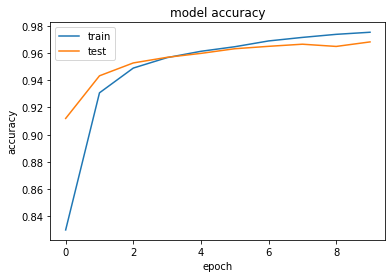

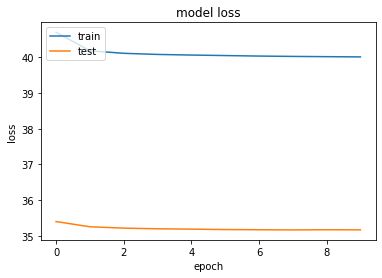

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.subplot(1,1,1)
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # summarize history for loss
# plt.plot(history.history['f1_tr'])
# plt.plot(history.history['f1_val'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()